# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own.

In [ ]:
from google.colab import files

uploaded = files.upload()  # This will open a file selection dialog


Saving style-image.png to style-image.png
Saving content-image.png to content-image.png


In [ ]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [ ]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

You can load in any images you want! Below, we've provided a helper function for loading in any type and size of image. The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

**TODO**: use your content vs style images.

In [ ]:
# load in content and style image
content = load_image('content-image.png')
# Resize style to match content, makes code easier
style = load_image('style-image.png', shape=content.shape[-2:])

In [ ]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

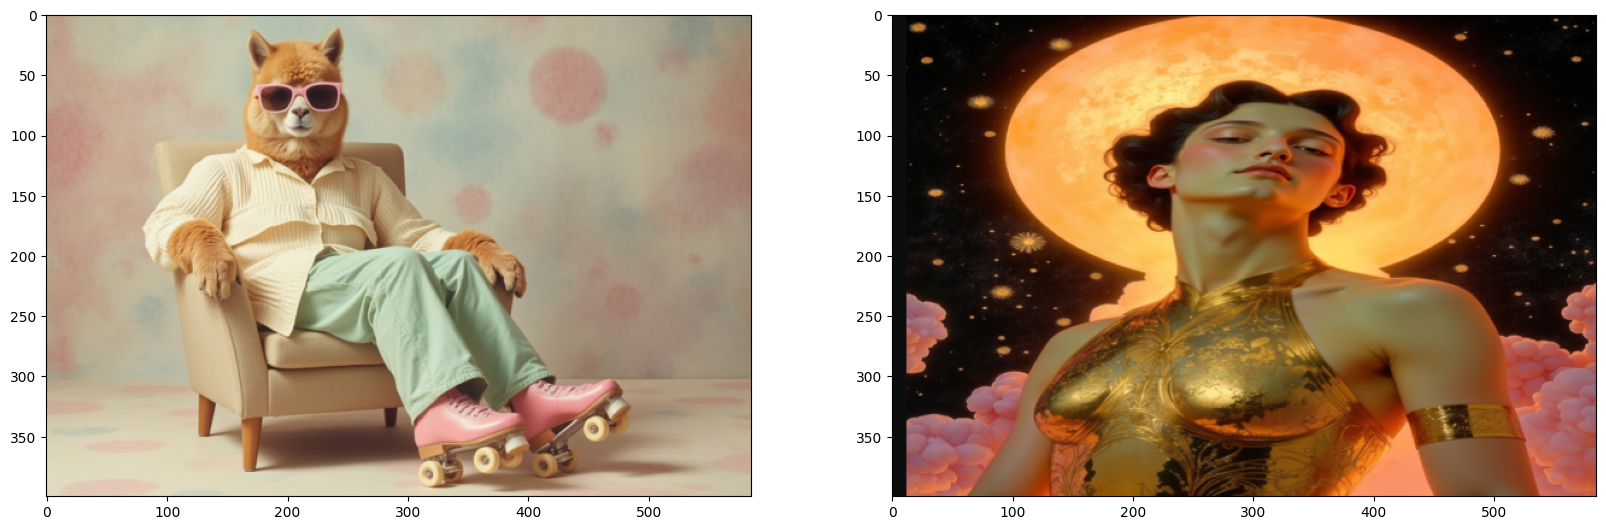

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [ ]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

#### **TODO**: complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

The first layer (0) to `conv1_1` has been done for you, below.

In [ ]:
def get_features(image, model, layers=None):
    """ Extracts features from selected layers of a pre-trained VGG model. """

    # Correct layer mapping for VGG19
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content representation layer
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

---
## Gram Matrix

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size()`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose

*Note: You can multiply two matrices using `torch.mm(matrix1, matrix2)`.*

#### TODO: Complete the `gram_matrix` function.

In [ ]:
def gram_matrix(tensor):
    """ Compute the Gram Matrix of a given tensor. """

    _, d, h, w = tensor.size()  # Get dimensions
    tensor = tensor.view(d, h * w)  # Reshape tensor
    gram = torch.mm(tensor, tensor.t())  # Compute Gram matrix

    return gram

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [ ]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

Below, you are given the option to weight the style representation at each relevant layer. It's suggested that you use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, you can expect to get _larger_ style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [ ]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses

You'll decide on a number of steps for which to update your image, this is similar to the training loop that you've seen before, only we are changing our _target_ image and nothing else about VGG19 or any other image. Therefore, the number of steps is really up to you to set! **I recommend using at least 2000 steps for good results.** But, you may want to start out with fewer steps if you are just testing out different weight values or experimenting with different images.

Inside the iteration loop, you'll calculate the content and style losses and update your target image, accordingly.

#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows:
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary `style_weights`.
> You'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`.
> Later, you'll see that this value is normalized by the size of the layer.

#### Total Loss

Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!

Intermittently, we'll print out this loss; don't be alarmed if the loss is very large. It takes some time for an image's style to change and you should focus on the appearance of your target image rather than any loss value. Still, you should see that this loss decreases over some number of iterations.

#### TODO: Define content, style, and total losses.

Step 400, Total loss: 27755850.0


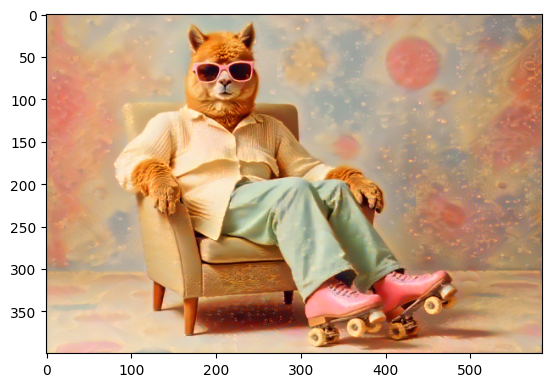

Step 800, Total loss: 14094367.0


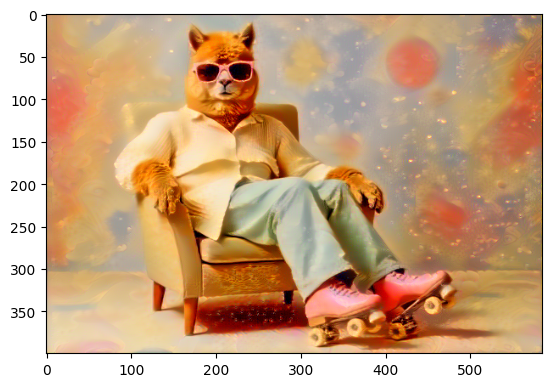

Step 1200, Total loss: 9598285.0


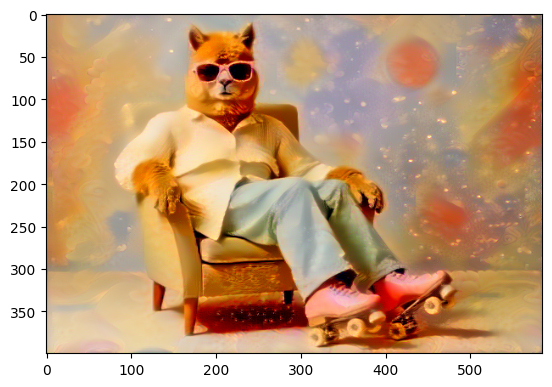

In [ ]:
# Define how often to display the target image
show_every = 400

# Define iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # Number of iterations

for ii in range(1, steps + 1):
    # **Recompute target features in every iteration**
    target_features = get_features(target, vgg)

    # Calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # Initialize the style loss
    style_loss = 0

    # Iterate through each style layer
    for layer in style_weights:
        # Get the target style representation
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape

        # Calculate the target Gram matrix
        target_gram = gram_matrix(target_feature)

        # Get the precomputed style Gram matrix
        style_gram = style_grams[layer]

        # Compute the style loss for this layer
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

        # Normalize and add to total style loss
        style_loss += layer_style_loss / (d * h * w)

    # Calculate the total loss (content + style)
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update the target image
    optimizer.zero_grad()
    total_loss.backward()  # <--- The issue was here
    optimizer.step()

    # Display intermediate results
    if ii % show_every == 0:
        print(f'Step {ii}, Total loss: {total_loss.item()}')
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

## Hyperparameter Tuning
In this section, we experiment with different values for `content_weight`, `style_weight`, `learning_rate`, and `iterations`. Modify these values and observe how they affect the final stylized image.

In [ ]:

# Define hyperparameters
content_weight = 1e5  # Strength of content preservation
style_weight = 1e10   # Strength of style transfer
learning_rate = 0.03  # Step size in optimization
num_iterations = 500  # Number of training steps

# Function to apply style transfer with these hyperparameters
def run_style_transfer(content_path, style_path, content_weight, style_weight, learning_rate, num_iterations):
    # Load content and style images
    content_image = load_image(content_path)
    style_image = load_image(style_path)

    # Perform style transfer
    output = neural_style_transfer(content_image, style_image,
                                   content_weight=content_weight,
                                   style_weight=style_weight,
                                   learning_rate=learning_rate,
                                   num_iterations=num_iterations)

    # Display the output image
    show_image(output)
    return output

# Run with the default hyperparameters
stylized_image = run_style_transfer('/mnt/data/content-image.png', '/mnt/data/style-image.png',
                                    content_weight, style_weight, learning_rate, num_iterations)


### Experimenting with Hyperparameters
Try modifying the values below and re-run the previous cell to observe the effects.

- **Lower `style_weight`** (e.g., `1e8`): The output image will retain more content details.
- **Higher `style_weight`** (e.g., `1e12`): The image will be more stylized but might lose content details.
- **Lower `content_weight`** (e.g., `1e4`): Content structure may be less recognizable.
- **Higher `content_weight`** (e.g., `1e6`): The result might look more like the original content image.
- **Changing `learning_rate`**: A high value might result in instability, while a low value slows convergence.
- **Increasing `num_iterations`**: More training steps usually lead to better results but take longer.